In [12]:
import pandas as pd # Make sure that you have openpyxl installed so that you can open newer excel files
import pandas.api.types as pdtypes
import numpy as np
import patchworklib as pw
import os 
from zipfile import is_zipfile, ZipFile
from datetime import date
from plotnine import ggplot, geom_line, aes, theme_minimal, geom_tile, geom_label,\
                     scale_fill_distiller, labs, theme, element_text
import plotly.graph_objects as go

In [13]:
# These first three functions are just utils
# that allow me to work with categorical 
# variables in Pandas DataFrames
##############################################################################
def as_categorical(c, copy=True):
    if not pdtypes.is_categorical_dtype(c):
        c = pd.Categorical(c)
    elif copy:
        c = c.copy()
    return c

def cat_rev(c):
    c = as_categorical(c)
    c.reorder_categories(c.categories[::-1], ordered=True) #issue was here
    return c

def cat_inorder(c, ordered=None):
    kwargs = {} if ordered is None else {'ordered': ordered}
    if isinstance(c, (pd.Series, pd.Categorical)):
        cats = c[~pd.isnull(c)].unique()
        if hasattr(cats, 'to_list'):
            cats = cats.to_list()
    elif hasattr(c, 'dtype'):
        cats = pd.unique(c[~pd.isnull(c)])
    else:
        cats = pd.unique([
            x for x, keep in zip(c, ~pd.isnull(c))
            if keep
        ])
    return pd.Categorical(c, categories=cats, **kwargs)
#############################################################################

def extractFolder(inputFilesDir,unzippedFilesDir):
    for file in os.listdir(inputFilesDir):   # get the list of files
        if is_zipfile(inputFilesDir+file): # if it is a zipfile, extract it
            with ZipFile(inputFilesDir+file) as item: # treat the file as a zip
                item.extractall(unzippedFilesDir)  # extract it into a new folder

def cleanTermStructureSheet(filename,foldername,sheetName):
    df = pd.read_excel(foldername+filename, sheet_name=sheetName, header=1, engine='openpyxl')
    df.drop(['Unnamed: 0'], axis=1, inplace=True) # Blank column - artifact of the dataset
    df = df.iloc[8:,:] # Dropping all unnessary columns 
    df.rename(columns={"Main menu": "Tenor"}, inplace=True)
    df.set_index("Tenor", inplace=True)
    return df

def getDateFromFileName(filename):
    dateString = filename.split('_')[2]
    yearString = dateString[:4]
    monthString = dateString[4:6]
    dayString = dateString[6:]
    return date(int(yearString),int(monthString),int(dayString))

def getCountrieslist(inputFilesDir):
    return pd.read_csv(inputFilesDir+"countries.csv").columns.to_list()

def getFilteredFileList(unzippedFilesDir,fileType):
    allFiles = os.listdir(unzippedFilesDir)
    filteredList = [file for file in allFiles if fileType in file]
    return filteredList 

def createCountriesDict(countries, unzippedFilesDir,fileType, sheetName):
    countriesDict = {}
    for country in countries:
        countriesDict[country] = {}

    for filename in getFilteredFileList(unzippedFilesDir,fileType):
        dateIndex = getDateFromFileName(filename)
        allTermStructures = cleanTermStructureSheet(filename,unzippedFilesDir,sheetName)
        for country in countries:
            countriesDict[country][dateIndex] =  allTermStructures.loc[:,country]

    return countriesDict

def plotCurvesOverTime(countriesDict, country, colourScale):
    countryData = pd.DataFrame(countriesDict[country]).sort_index(axis = 1)
    dates = countryData.columns
    tenors = countryData.index.values
    camera = dict(
        up = dict(x=0, y=0, z=1), 
        center = dict(x=0, y=0, z=0), 
        eye = dict(x=1.6, y=1.6, z=0.5 )
    )

    fig = go.Figure(data=[go.Surface(z=countryData.values, 
                                     x=dates, 
                                     y=tenors,
                                     opacity = 0.8,
                                     colorscale=colourScale, 
                                     colorbar_thickness = 25, 
                                     colorbar_len = 0.75, 
                                    
                      )])

    fig.update_layout(scene_camera = camera,
                    scene=dict(yaxis_title='Tenor',
                            xaxis_title='Date',
                            zaxis_title='Yield',
                            aspectratio = dict(x = 1, y = 1.4, z= 0.75)),
                    title=f'{country} Curve Progression since 2022', autosize=False,
                    width=1000, height=700,
                    margin=dict(l=50, r=20, b=10, t=50), 
                    paper_bgcolor="LightSteelBlue", 
                    )

    fig.show()

def getSubsetBasedOnTenor(country, countriesDict, tenorsOfInterest):
    tenorsOfInterest = [tenor - 1 for tenor in tenorsOfInterest]
    return pd.DataFrame(countriesDict[country]).iloc[tenorsOfInterest,:].T

def correlationMatrixDataframeHelper(country,countriesDict,tenorsOfInterest):
    df = getSubsetBasedOnTenor(country, countriesDict, tenorsOfInterest)
    newColumns = [f'{country}_{tenor}Y' for tenor in df.columns.values]
    df.columns = newColumns
    return df

def createCrossCountryCrossTenorCorrelationMatrix(countries, tenors, countriesDict):
    elementsOfCorrelationMatrix = []
    for country in countries:
        elementsOfCorrelationMatrix.append(correlationMatrixDataframeHelper(country,countriesDict,tenors))
    correlationDataFrame = pd.concat(elementsOfCorrelationMatrix, axis = 1)
    crossTenorCountryCorrelation = np.round(correlationDataFrame.diff().dropna().corr(),2)
    return crossTenorCountryCorrelation

def tidyCorrelationMatrix(corrMatrix):
    df = (
            corrMatrix
            .melt(ignore_index = False)
            .reset_index()
            .set_axis(labels= ['var1', 'var2', 'Correlation'], axis = 1)
            .assign(labText = lambda x: np.round(x['Correlation'],2))
            .assign(
                var1 = lambda x : cat_inorder(x['var1']),
                var2 = lambda x : cat_rev(cat_inorder(x['var2']))
            )  
    )
    return df

def ggplot2CorrelationMatrix(tidyCorr):
    return (
        ggplot(mapping = aes('var1', 'var2', fill = "Correlation"), data = tidyCorr)
        + geom_tile()
        + geom_label(aes(label = "labText"), label_size = 0,  size = 7)
        + scale_fill_distiller()
        + theme_minimal()
        + labs(title = 'Cross-Currency & Cross-Tenor Correlation', 
            subtitle = "Exploring Curve Correlation in Different Countries", 
            x = "", y = "")
        + theme(axis_text_x = element_text(rotation = 90, hjust = 1), figure_size = (12,9))

    )

def performPCA(dataFrame):
    # Note the dates have to be the rows 
    # and the columns must be the tenors
    diffDataFrame = dataFrame.diff().dropna()
    X = diffDataFrame.values 
    X = X - np.mean(X,axis = 0) 
    Cov_X = np.cov(X.astype(float), rowvar = False) 
    eigen = np.linalg.eig(Cov_X)

    # Eigen Value Calculation in Python is a numerical calc that is prone to numerical over and under flow
    # Therefore there is a chance that the eigen vectors may be complex numbers. However, these values 
    # are small and can be safely igored. 
    eigenVectors = np.real(eigen[1])
    principalComponents = X @ eigenVectors 
   
    return principalComponents, diffDataFrame

def pcaTenorCorrelation(startTenor,endTenor,country,countriesDict):
    tenorsOfInterest = np.arange(startTenor, endTenor+1, 1)
    numOfTenors = len(tenorsOfInterest)
    principalComponents, subsetDiffDataFrame = performPCA(getSubsetBasedOnTenor(country, countriesDict, tenorsOfInterest))
    df1 = subsetDiffDataFrame.reset_index(drop = True)
    df2 = pd.DataFrame(principalComponents[:,:3],columns=['Level - PC1','Slope - PC2','Twist - PC3'])
    df3 = np.round(pd.concat([df1,df2], axis= 1).corr(),4).iloc[:numOfTenors, -3:]
    return df3.rename_axis('Tenor').reset_index().melt(id_vars = "Tenor").copy()

def plotPcaTenorCorrelation(startTenor,endTenor,country,countriesDict):
    pcaDf = pcaTenorCorrelation(startTenor,endTenor,country,countriesDict)
    return (
        ggplot(pcaDf)  # What data to use
        + aes(x="Tenor", y="value",color = "variable")  # What variable to use
        + geom_line()  # Geometric object to use for drawing
        + labs(
            x = 'Tenor', 
            y = 'Correlation', 
            color = 'Principal Components', 
            title = 'Correlations of Principle Components (PC) vs Tenors',
            subtitle = f'Visualising the PCs for {country} {startTenor}Y-{endTenor}Y Curve'
        )
    )

In [14]:
inputFilesDir = "inputData/"
unzippedFilesDir = "unzippedFiles/"
fileType = "Term_Structures"
sheetName = "RFR_spot_no_VA"

extractFolder(inputFilesDir,unzippedFilesDir)
countries = getCountrieslist(inputFilesDir)
countriesDict = createCountriesDict(countries, unzippedFilesDir,fileType, sheetName)

In [15]:
plotCurvesOverTime(countriesDict,"United States", "Reds")

In [16]:
plotCurvesOverTime(countriesDict,"Euro", "Blues")

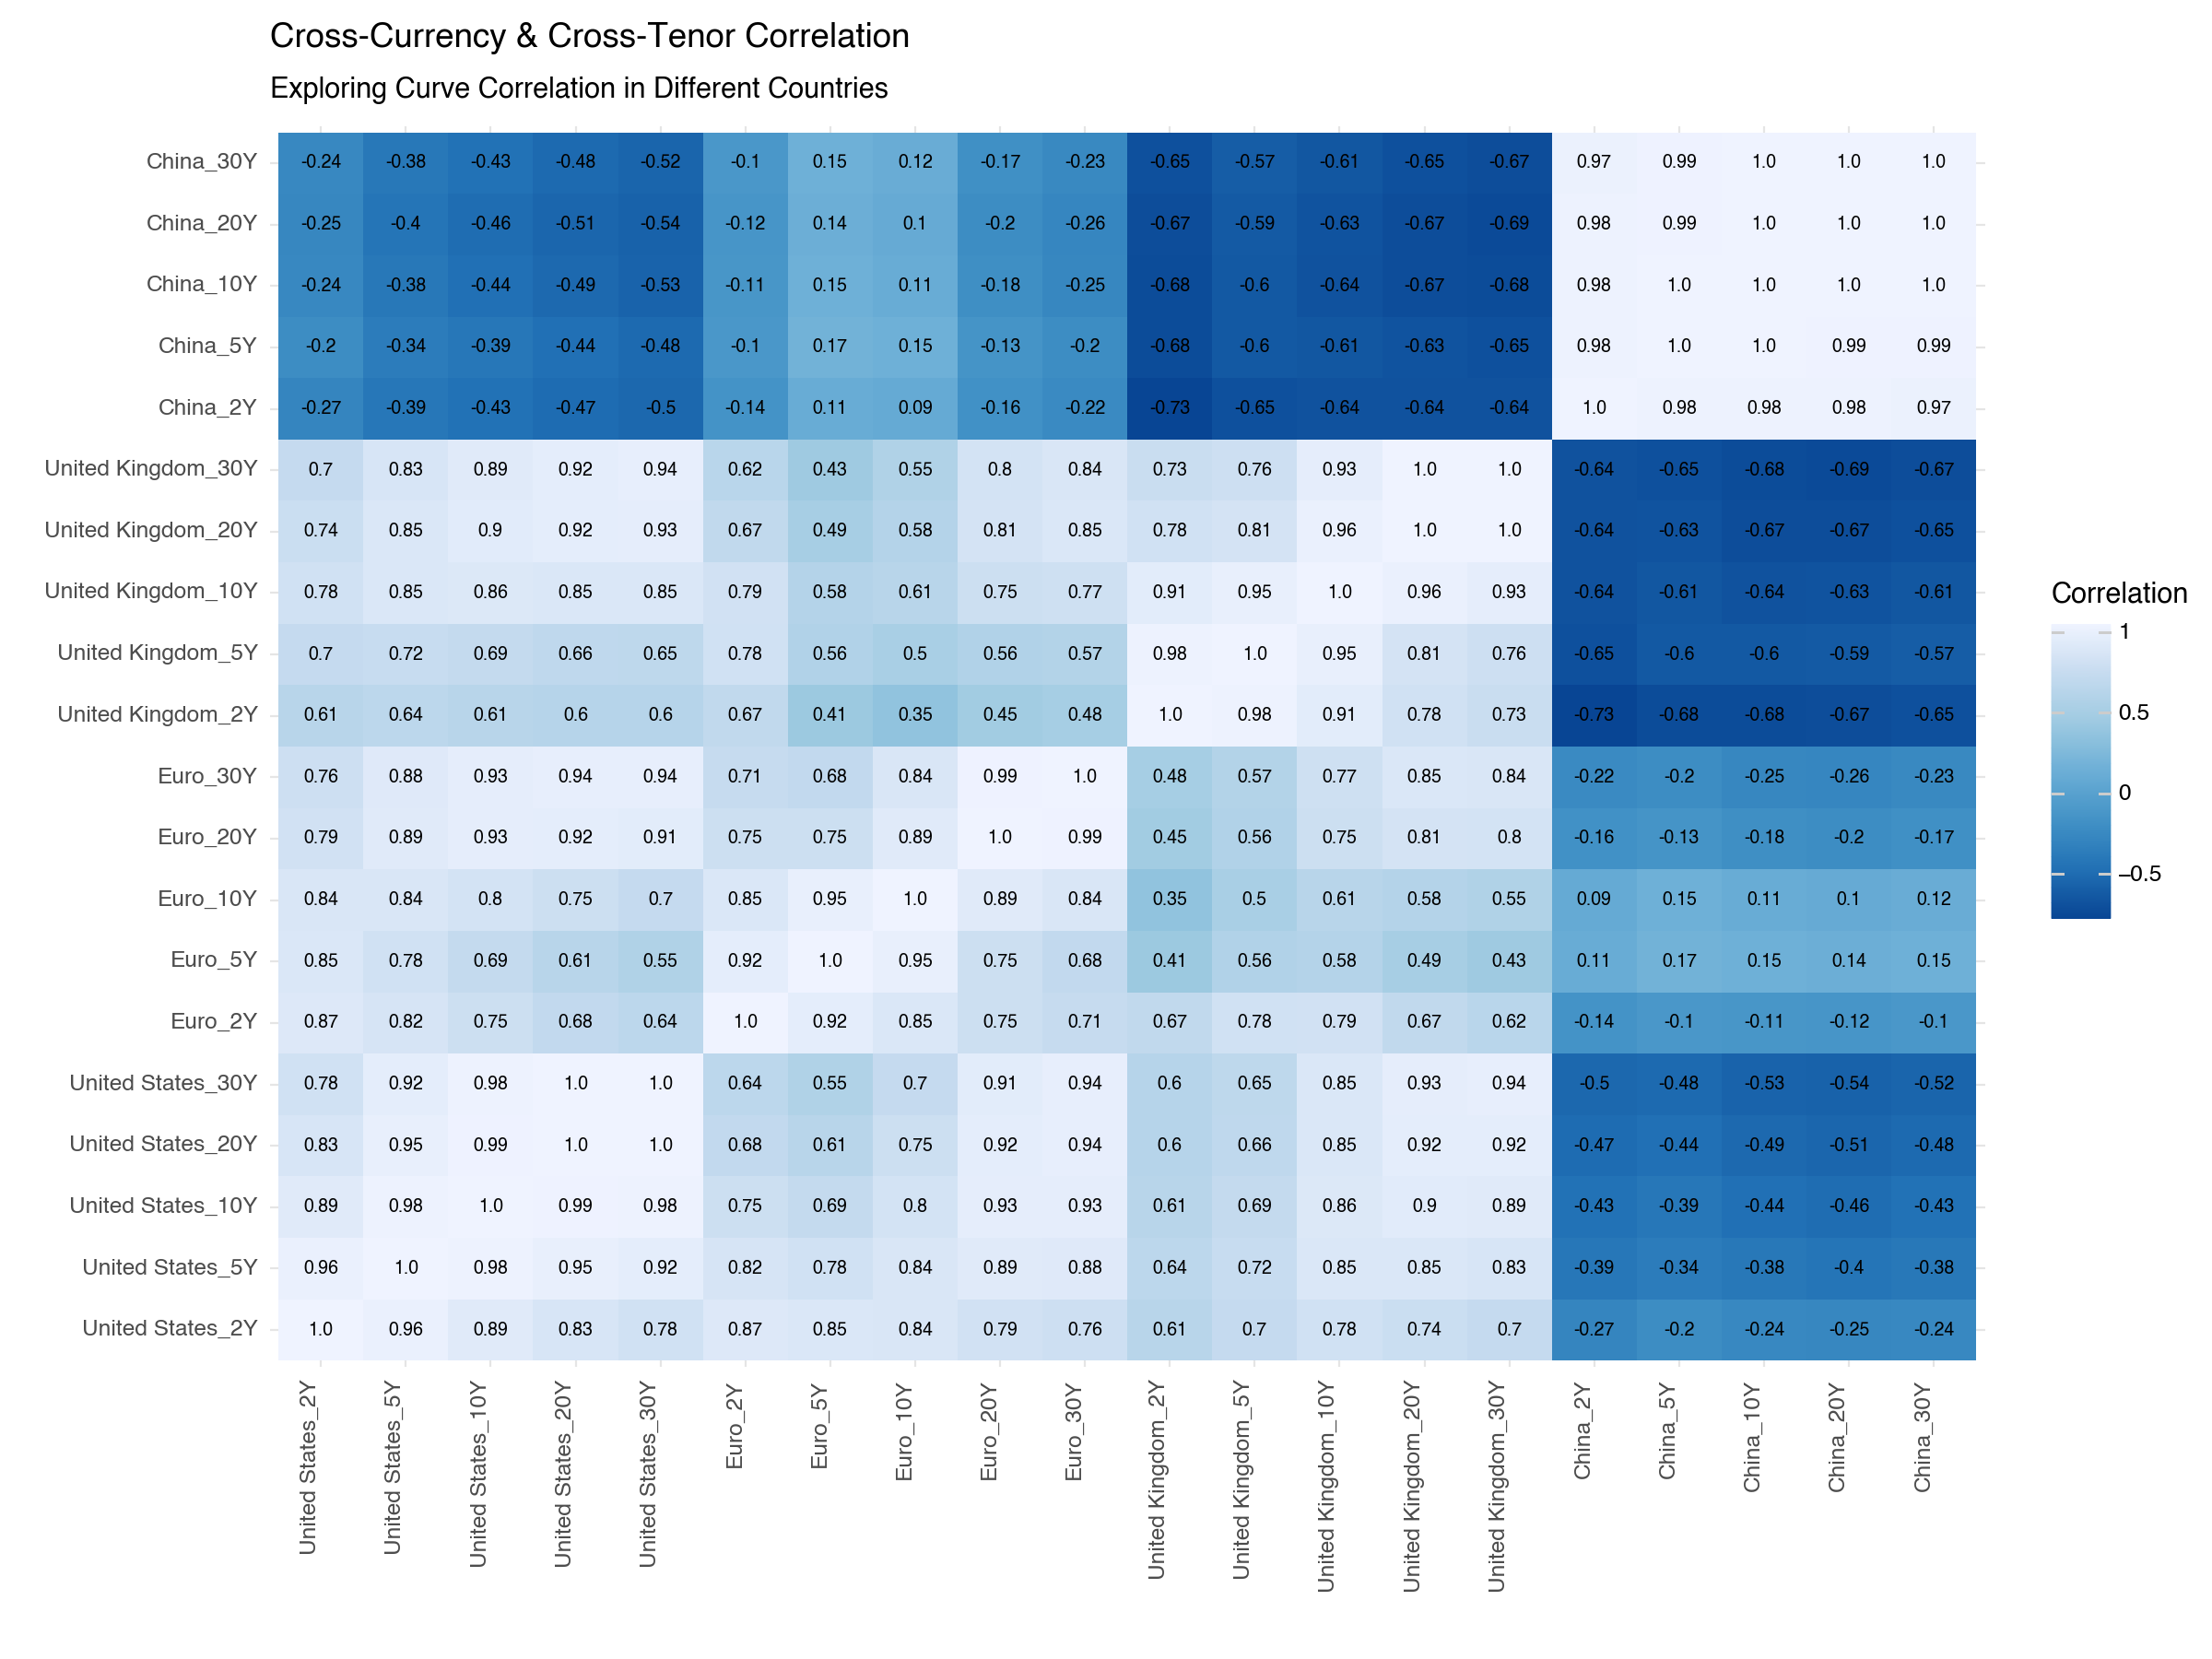

<Figure Size: (1200 x 900)>

In [17]:
countriesForCorrelation = ["United States", "Euro", "United Kingdom", "China"]
tenorsOfInterest = [2, 5, 10, 20, 30]
corrMatrix =  createCrossCountryCrossTenorCorrelationMatrix(countriesForCorrelation, tenorsOfInterest, countriesDict)
tidyCorr = tidyCorrelationMatrix(corrMatrix)
ggplot2CorrelationMatrix(tidyCorr)

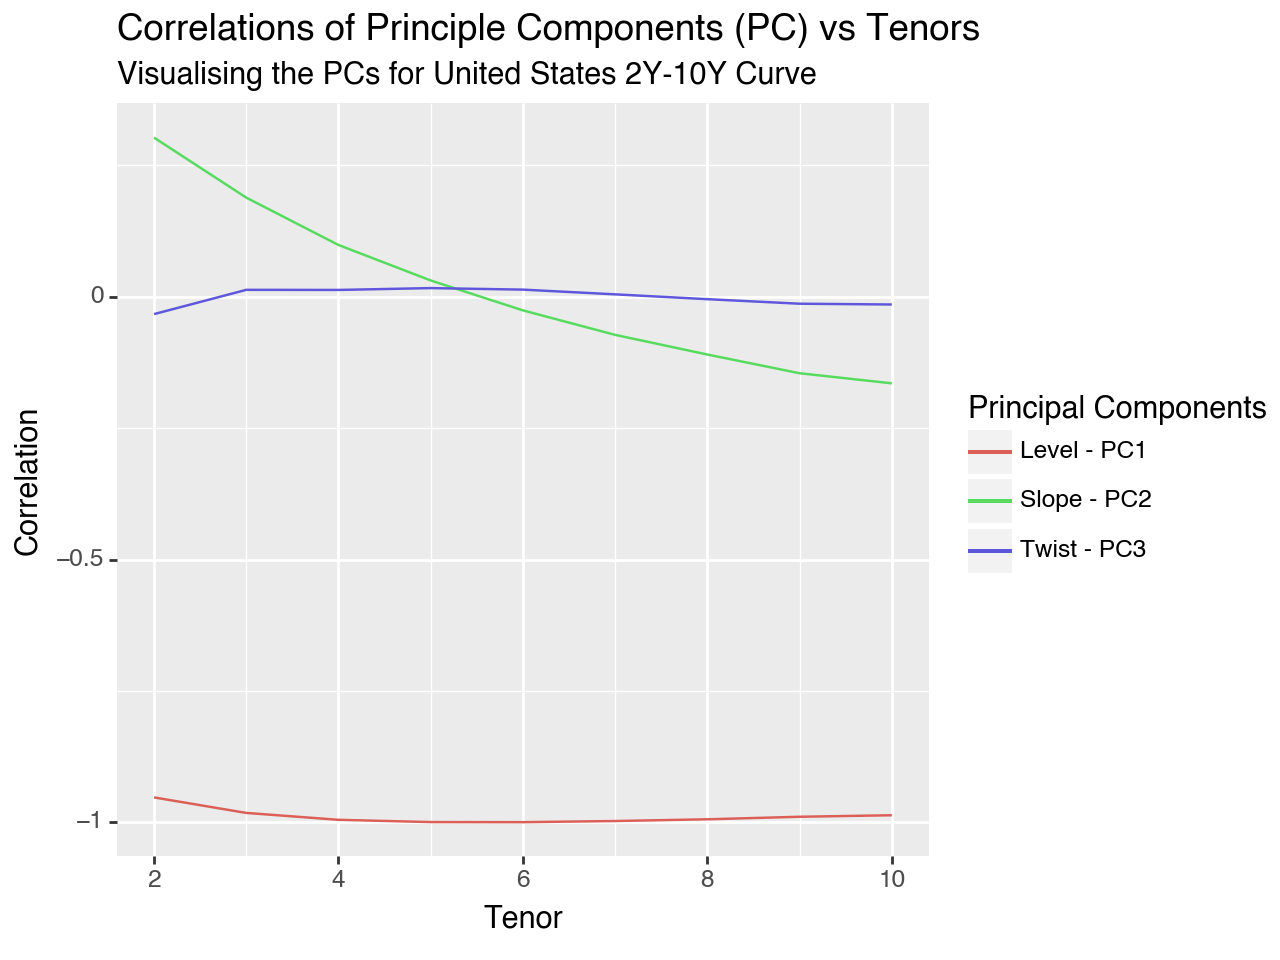

<Figure Size: (640 x 480)>

In [18]:
startTenor = 2
endTenor   = 10
country = "United States"
plotPcaTenorCorrelation(startTenor,endTenor,country,countriesDict)

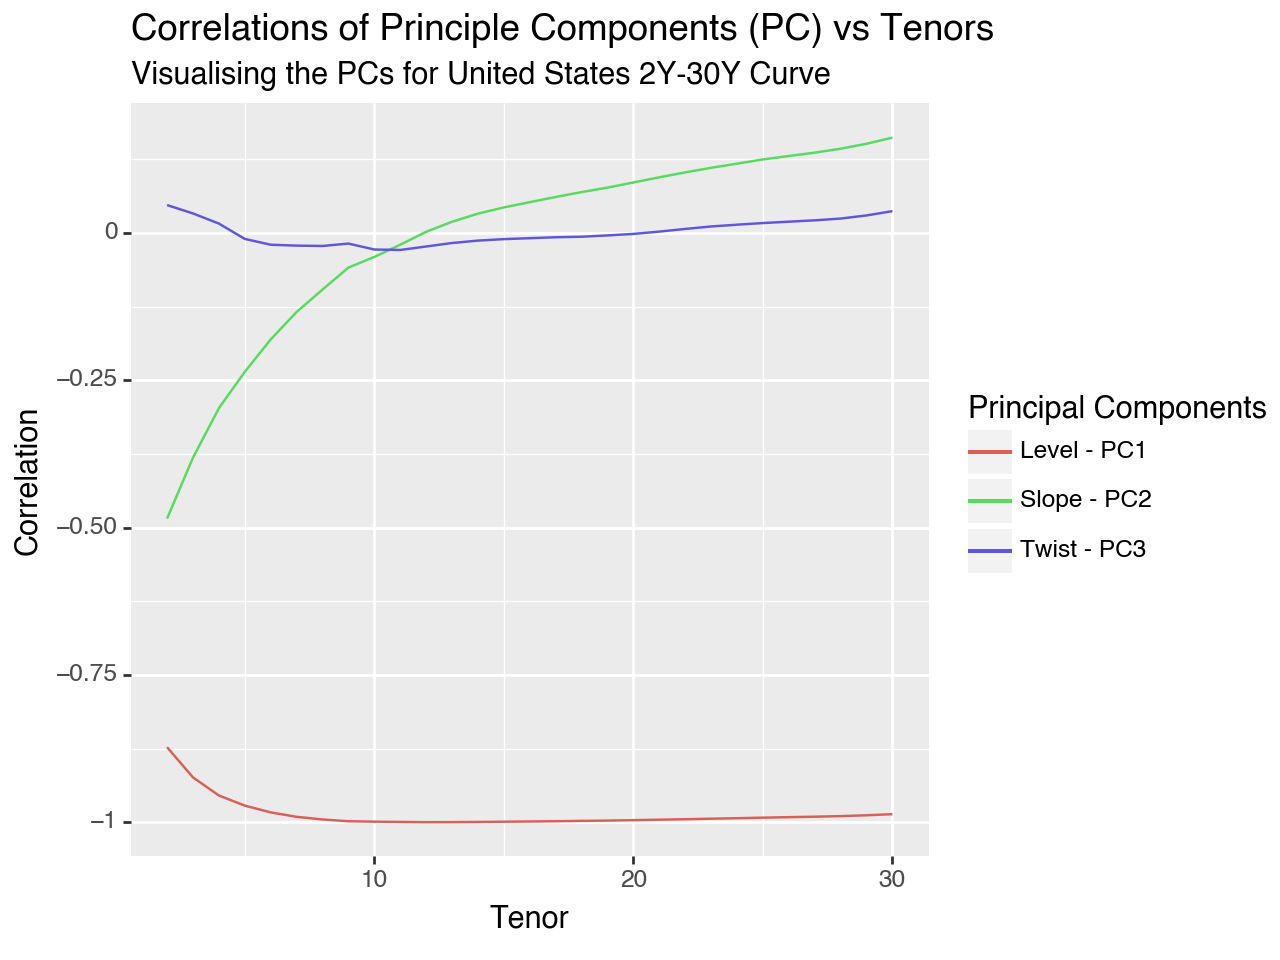

<Figure Size: (640 x 480)>

In [19]:
startTenor = 2
endTenor   = 30
country = "United States"
plotPcaTenorCorrelation(startTenor,endTenor,country,countriesDict)

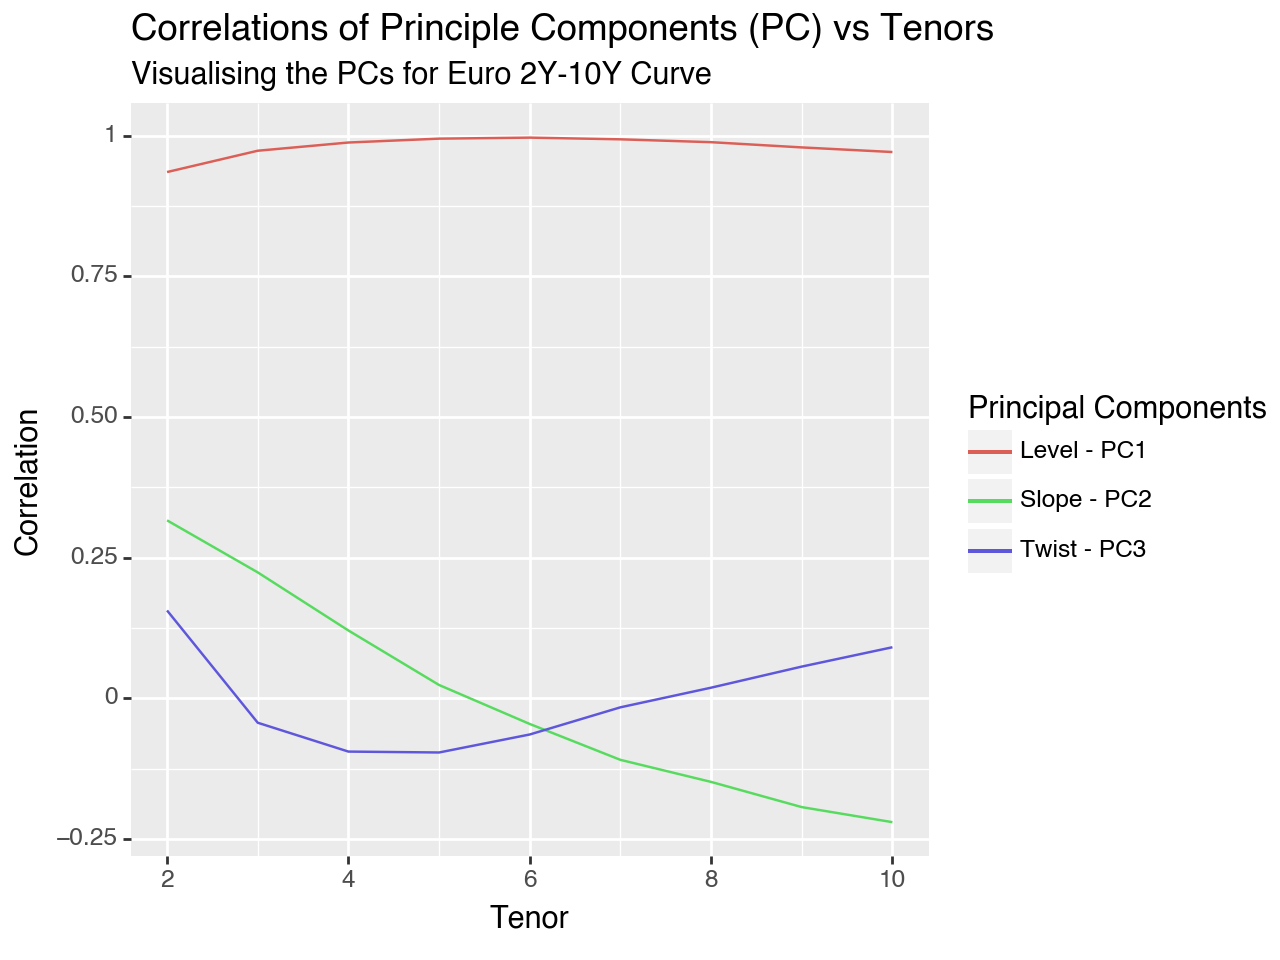

<Figure Size: (640 x 480)>

In [20]:
startTenor = 2
endTenor  = 10
country = "Euro"
plotPcaTenorCorrelation(startTenor,endTenor,country,countriesDict)

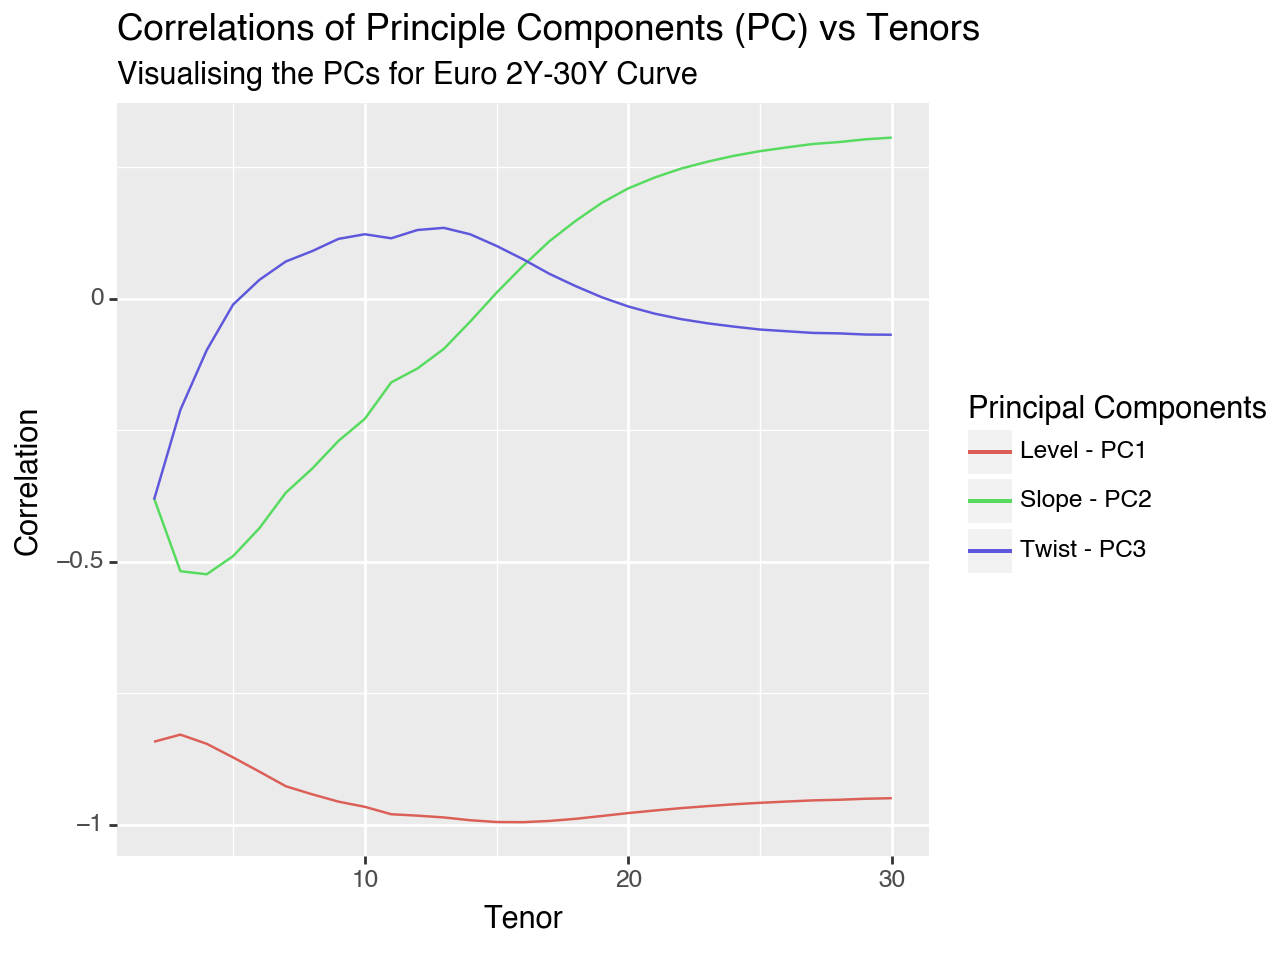

<Figure Size: (640 x 480)>

In [21]:
startTenor = 2
endTenor   = 30
country = "Euro"
plotPcaTenorCorrelation(startTenor,endTenor,country,countriesDict)